In [77]:
# noexport

!typech retention_utils.ipynb

[NbConvertApp] Converting notebook retention_utils.ipynb to python


In [3]:
from r_utils import r, r_assign

In [4]:
from train_utils import *

In [5]:
# noexport

jsonmemo_module.set_lowmem(True)

In [6]:
@msgpackmemo
def get_install_to_dates_active_list():
  output = {}
  for install,dates_active_set in get_install_to_dates_active_set().items():
    dates_active_list = sorted(list(dates_active_set))
    output[install] = dates_active_list
  return output

In [7]:
def get_install_to_dates_active_set():
  install_active_dates = get_collection_items('install_active_dates')
  output = {}
  #weird_items = []
  for item in install_active_dates:
    if 'day' not in item or 'install' not in item:
      #weird_items.append(item)
      continue
    day = item['day']
    install = item['install']
    if install not in output:
      output[install] = set()
    output[install].add(day)
  #print(len(weird_items))
  #print(weird_items[:100])
  return output

#print(user_active_dates[0])

In [8]:
@msgpackmemo
def get_user_to_dates_active_list():
  output = {}
  for user,dates_active_set in get_user_to_dates_active_set().items():
    dates_active_list = sorted(list(dates_active_set))
    output[user] = dates_active_list
  return output

In [9]:
def get_user_to_dates_active_set():
  user_active_dates = get_collection_items('user_active_dates')
  output = {}
  #weird_items = []
  for item in user_active_dates:
    if 'day' not in item or 'user' not in item:
      #weird_items.append(item)
      continue
    day = item['day']
    user = item['user']
    if user not in output:
      output[user] = set()
    output[user].add(day)
  #print(len(weird_items))
  #print(weird_items[:100])
  return output

#print(user_active_dates[0])

In [10]:
def get_date_to_users_active_set():
  output = {}
  for user,dates_active_list in get_user_to_dates_active_list().items():
    for date in dates_active_list:
      if date not in output:
        output[date] = set()
      output[date].add(user)
  return output

In [11]:
@msgpackmemo
def get_date_to_users_active_list():
  output = {}
  for date,users_active_set in get_date_to_users_active_set().items():
    output[date] = sorted(list(users_active_set))
  return output

In [12]:
def get_date_to_installs_active_set():
  output = {}
  for install,dates_active_list in get_install_to_dates_active_list().items():
    for date in dates_active_list:
      if date not in output:
        output[date] = set()
      output[date].add(install)
  return output

In [13]:
@msgpackmemo
def get_date_to_installs_active_list():
  output = {}
  for date,installs_active_set in get_date_to_installs_active_set().items():
    output[date] = sorted(list(installs_active_set))
  return output

In [14]:
from datetime import datetime
from dateutil import tz

def get_epoch_start_arrowdate():
  return arrow.get(datetime(2016, 1, 1)) #, tz.gettz('US/Pacific'))

def convert_date_to_arrowdate(date):
  year = int(date[0:4])
  month = int(date[4:6])
  day = int(date[6:8])
  return arrow.get(datetime(year, month, day)) #, tz.gettz('US/Pacific'))

def get_dump_date():
  return sorted(list(get_date_to_users_active_list().keys()))[-1]

def get_dump_arrowdate():
  dump_date = get_dump_date()
  return convert_date_to_arrowdate(dump_date)

def get_dump_epoch():
  dump_arrowdate = get_dump_arrowdate()
  return convert_arrowdate_to_epoch(dump_arrowdate)

def convert_arrowdate_to_epoch(arrowdate):
  return (arrowdate - get_epoch_start_arrowdate()).days

def convert_date_to_epoch(date):
  arrowdate = convert_date_to_arrowdate(date)
  return convert_arrowdate_to_epoch(arrowdate)

In [15]:
@msgpackmemo
def get_user_to_retention_info():
  output = {}
  dump_epoch = get_dump_epoch()
  for user,dates_active in get_user_to_dates_active_list().items():
    epochs_active = sorted([convert_date_to_epoch(x) for x in dates_active])
    first_active = epochs_active[0]
    last_active = epochs_active[-1]
    days_alive = last_active - first_active
    is_alive = (dump_epoch - last_active) <= 4
    attritioned = not is_alive
    output[user] = {'lifetime': days_alive, 'attritioned': attritioned}
  return output

In [16]:
@msgpackmemo
def get_install_to_retention_info():
  output = {}
  dump_epoch = get_dump_epoch()
  for install,dates_active in get_install_to_dates_active_list().items():
    epochs_active = sorted([convert_date_to_epoch(x) for x in dates_active])
    first_active = epochs_active[0]
    last_active = epochs_active[-1]
    days_alive = last_active - first_active
    is_alive = (dump_epoch - last_active) <= 4
    attritioned = not is_alive
    output[install] = {'lifetime': days_alive, 'attritioned': attritioned}
  return output

In [17]:
def to_dataframe(list_of_dict):
  columns = list(list_of_dict[0].keys())
  d = {}
  for column in columns:
    d[column] = []
    for item in list_of_dict:
      d[column].append(item[column])
  return pd.DataFrame(d)


In [18]:
def get_all_user_retentions_dataframe():
  user_retentions = []
  for user,retention_info in get_user_to_retention_info().items():
    user_retentions.append(retention_info)
  return to_dataframe(user_retentions)

In [19]:
def get_retention_info_for_groups_to_installs(group_to_installs, category_name):
  output = []
  install_to_retention_info = get_install_to_retention_info()
  for group,install_list in group_to_installs.items():
    for install in install_list:
      if get_is_install_unofficial(install):
        continue
      retention_info = install_to_retention_info[install]
      output.append({
        'lifetime': retention_info['lifetime'],
        'attritioned': retention_info['attritioned'],
        category_name: group,
      }) 
  return to_dataframe(output)

In [20]:
def get_retention_info_for_groups_to_users(group_to_users, category_name):
  output = []
  user_to_retention_info = get_user_to_retention_info()
  for group,user_list in group_to_users.items():
    for user in user_list:
      if get_is_user_unofficial(user):
        continue
      retention_info = user_to_retention_info[user]
      output.append({
        'lifetime': retention_info['lifetime'],
        'attritioned': retention_info['attritioned'],
        category_name: group,
      }) 
  return to_dataframe(output)

In [21]:
def get_retention_info_by_frequency_of_choose_difficulty_by_install():
  condition_to_installs = get_conditions_to_install_list_in_abtest('frequency_of_choose_difficulty', ['0.0', '0.25', '0.5', '1.0'])
  return get_retention_info_for_groups_to_installs(condition_to_installs, 'frequency_of_choose_difficulty')

In [22]:
def get_retention_info_by_frequency_of_choose_difficulty_by_user():
  condition_to_users = get_conditions_to_user_list_in_abtest('frequency_of_choose_difficulty', ['0.0', '0.25', '0.5', '1.0'])
  return get_retention_info_for_groups_to_users(condition_to_users, 'frequency_of_choose_difficulty')

In [23]:
# def get_retention_info_by_frequency_of_choose_difficulty_by_install():
#   output = []
#   install_list = get_installs_with_choose_difficulty()
#   install_to_retention_info = get_install_to_retention_info()
#   for install in install_list:
#     if get_is_install_unofficial(install):
#       continue
#     abtest_settings = get_abtest_settings_for_install(install)
#     frequency_of_choose_difficulty = abtest_settings.get('frequency_of_choose_difficulty')
#     if frequency_of_choose_difficulty == None:
#       continue
#     conditions = get_abtest_experiment_conditions_for_install(install).get('frequency_of_choose_difficulty')
#     if conditions != ['0.0', '0.25', '0.5', '1.0']:
#       continue
#     retention_info = install_to_retention_info[install]
#     output.append({
#       'lifetime': retention_info['lifetime'],
#       'attritioned': retention_info['attritioned'],
#       'frequency_of_choose_difficulty': frequency_of_choose_difficulty,
#     })
#   return to_dataframe(output)

In [24]:
# def get_retention_info_by_frequency_of_choose_difficulty():
#   output = []
#   user_list = get_users_with_choose_difficulty()
#   user_to_retention_info = get_user_to_retention_info()
#   for user in user_list:
#     if get_is_user_unofficial(user):
#       continue
#     abtest_settings = get_abtest_settings(user)
#     frequency_of_choose_difficulty = abtest_settings.get('frequency_of_choose_difficulty')
#     if frequency_of_choose_difficulty == None:
#       continue
#     conditions = get_abtest_experiment_conditions(user).get('frequency_of_choose_difficulty')
#     if conditions != ['0.0', '0.25', '0.5', '1.0']:
#       continue
#     retention_info = user_to_retention_info[user]
#     output.append({
#       'lifetime': retention_info['lifetime'],
#       'attritioned': retention_info['attritioned'],
#       'frequency_of_choose_difficulty': frequency_of_choose_difficulty,
#     })
#   return to_dataframe(output)

In [25]:
def plot_attrition(pandas_df, varname):
  r_assign('plot_attrition_df', pandas_df)
  r(f"""
  plot_attrition_df$lifetime <- as.numeric(plot_attrition_df$lifetime)
  plot_attrition_df$attritioned <- as.logical(plot_attrition_df$attritioned)
  plot_attrition_df${varname} <- as.factor(plot_attrition_df${varname})
  library("survival")
  library("survminer")
  fit <- survfit(Surv(lifetime, attritioned) ~ {varname}, data=plot_attrition_df)
  summary(fit)
  ggsurvplot(fit,
    pval = TRUE, conf.int = TRUE,
    risk.table = TRUE, # Add risk table
    risk.table.col = "strata", # Change risk table color by groups
    linetype = "strata", # Change line type by groups
    surv.median.line = "hv", # Specify median survival
    ggtheme = theme_bw(), # Change ggplot2 theme
  )
  """)
#   r(f"""
#   plot_attrition_df$lifetime <- as.numeric(plot_attrition_df$lifetime)
#   plot_attrition_df$attritioned <- as.logical(plot_attrition_df$attritioned)
#   plot_attrition_df${varname} <- as.factor(plot_attrition_df${varname})
#   library("survival")
#   library("survminer")
#   fit <- survfit(Surv(lifetime, attritioned) ~ {varname}, data=plot_attrition_df)
#   summary(fit)
#   plot_attrition_func <- function() {{
    
#   }}
#   """)
#   %R -w 1000 print(plot_attrition_func())


In [72]:
def plot_attrition_for_abtest_groups_by_install(abtest_name, groups):
  condition_to_installs = get_conditions_to_install_list_in_abtest(abtest_name, groups)
  retention_info = get_retention_info_for_groups_to_installs(condition_to_installs, abtest_name)
  plot_attrition(retention_info, abtest_name)

def plot_attrition_for_abtest_groups_by_user(abtest_name, groups):
  condition_to_users = get_conditions_to_user_list_in_abtest(abtest_name, groups)
  retention_info = get_retention_info_for_groups_to_users(condition_to_users, abtest_name)
  plot_attrition(retention_info, abtest_name)

def plot_attrition_for_abtest_groups_by_install_unstrict(abtest_name, groups):
  condition_to_installs = get_conditions_to_install_list_in_abtest_unstrict(abtest_name)
  for k in list(condition_to_installs.keys()):
    if k not in groups:
      del condition_to_installs[k]
  retention_info = get_retention_info_for_groups_to_installs(condition_to_installs, abtest_name)
  plot_attrition(retention_info, abtest_name)

In [68]:
def get_conditions_to_install_list_in_abtest_unstrict(abtest_name):
  output = {}
  #for install in get_installs_with_choose_difficulty():
  for install in get_installs_with_experiment_vars():
    abtest_settings = get_abtest_settings_for_install(install)
    if abtest_name not in abtest_settings:
      continue
    condition = abtest_settings[abtest_name]
    #all_abtest_conditions = get_abtest_experiment_conditions_for_install(install)
    #if abtest_name not in all_abtest_conditions:
    #  continue
    #all_conditions = all_abtest_conditions[abtest_name]
    #if all_conditions != abtest_conditions:
    #  continue
    if condition not in output:
      output[condition] = []
    output[condition].append(install)
  return output


In [75]:
# def make_attrition_plot_by_install_for_frequency_of_choose_difficulty():
#   plot_attrition(get_retention_info_by_frequency_of_choose_difficulty_by_install(), 'frequency_of_choose_difficulty')

# def make_attrition_plot_by_user_for_frequency_of_choose_difficulty():
#   plot_attrition(get_retention_info_by_frequency_of_choose_difficulty_by_user(), 'frequency_of_choose_difficulty')

def make_attrition_plot_by_install_for_frequency_of_choose_difficulty():
  plot_attrition_for_abtest_groups_by_install('frequency_of_choose_difficulty', ['0.0', '0.25', '0.5', '1.0'])

def make_attrition_plot_by_user_for_frequency_of_choose_difficulty():
  plot_attrition_for_abtest_groups_by_user('frequency_of_choose_difficulty', ['0.0', '0.25', '0.5', '1.0'])

def make_attrition_plot_by_install_for_randomized_difficulty_assignments():
  plot_attrition_for_abtest_groups_by_install_unstrict('difficulty_selection_screen', ['survey_nochoice_nothing', 'survey_nochoice_easy', 'survey_nochoice_medium', 'survey_nochoice_hard'])


/usr/local/lib/python3.7/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:

载入需要的程辑包：ggplot2


/usr/local/lib/python3.7/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


/usr/local/lib/python3.7/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:

载入需要的程辑包：ggpubr


/usr/local/lib/python3.7/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:

载入需要的程辑包：magrittr




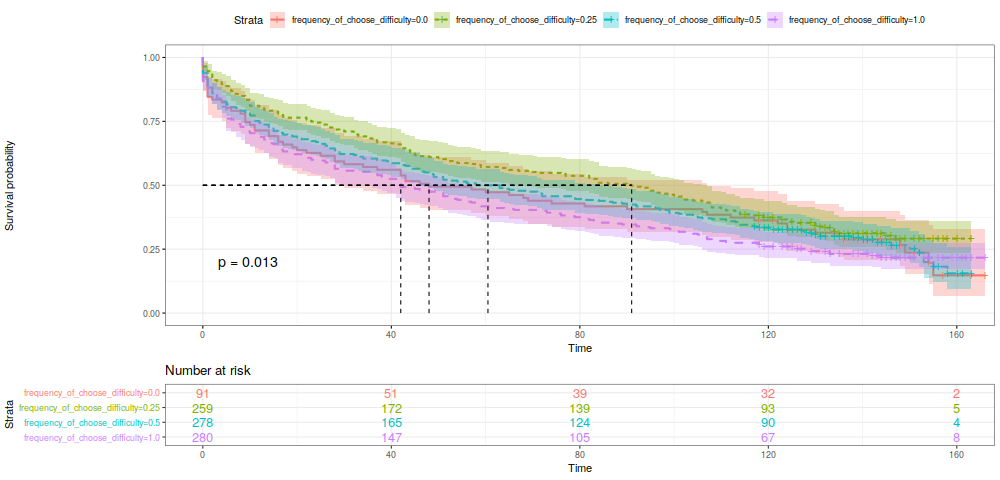

In [30]:
# noexport

make_attrition_plot_by_install_for_frequency_of_choose_difficulty()

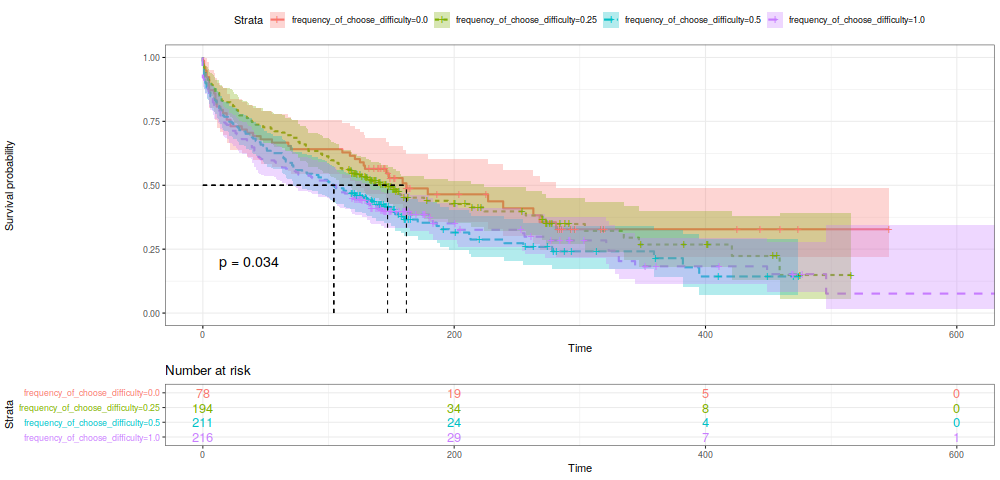

In [35]:
# noexport

make_attrition_plot_by_user_for_frequency_of_choose_difficulty()

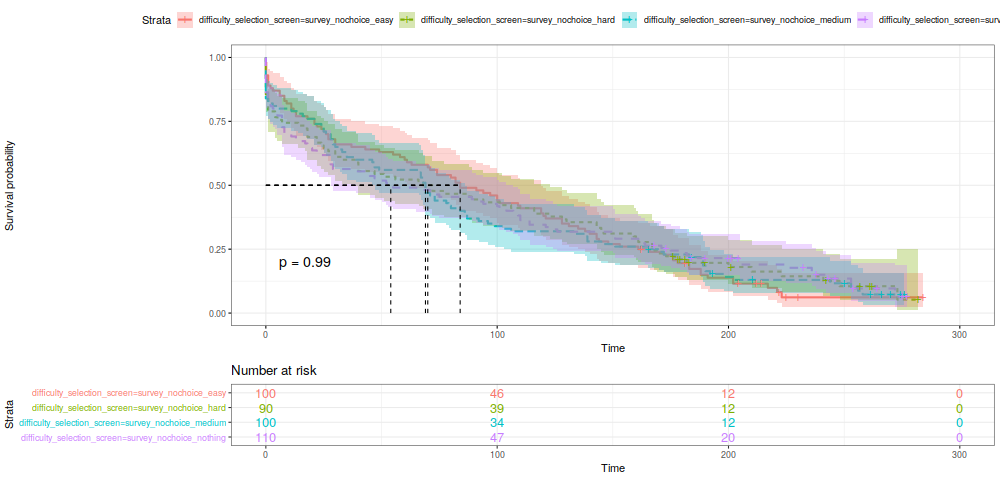

In [76]:
# noexport

make_attrition_plot_by_install_for_randomized_difficulty_assignments()

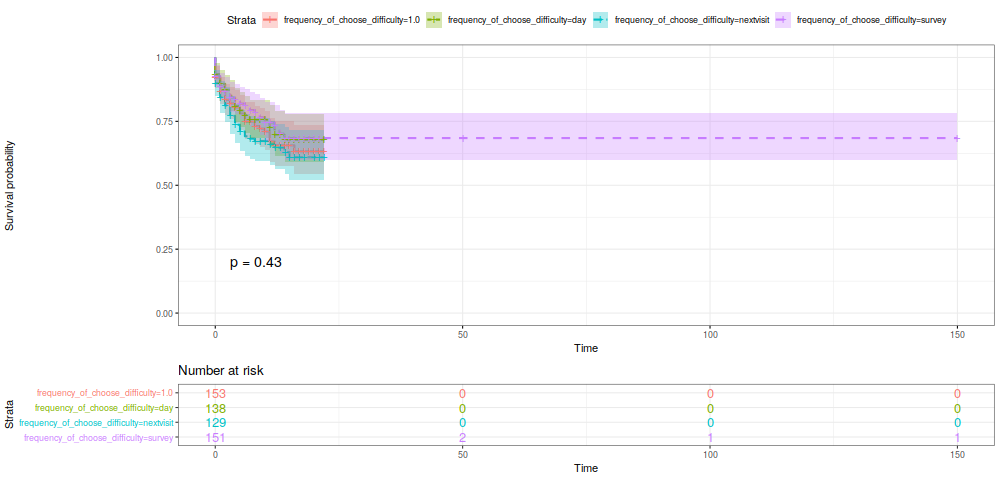

In [83]:
# noexport

plot_attrition_for_abtest_groups_by_install('frequency_of_choose_difficulty', ['1.0', 'nextvisit', 'day', 'survey'])

In [62]:
# def get_users_with_experiment_vars():
#   collection_names = get_collection_names()
#   output = []
#   for x in collection_names:
#     if x.endswith('_synced:experiment_vars'):
#       user = x.replace('_synced:experiment_vars', '')
#       output.append(user)
#   return output

# def get_installs_with_experiment_vars():
#   output = set()
#   user_list = get_users_with_choose_difficulty()
#   for user in user_list:
#     for item in get_collection_items(user + '_synced:experiment_vars'):
#       install_id = item.get('install_id')
#       if install_id == None:
#         continue
#       output.add(install_id)
#   return sorted(list(output))

In [63]:
#print(len(get_installs_with_experiment_vars()))

9654


In [64]:


# def get_abtest_settings_for_install_uncached(install_id):
#   output = {}
#   collection_items = get_collection_for_install(install_id, 'synced:experiment_vars')
#   for item in collection_items:
#     if 'key' not in item:
#       continue
#     if 'val' not in item:
#       continue
#     key = item['key']
#     val = item['val']
#     output[key] = val
#     #if key == 'difficulty_selection_screen' and val != 'nodefault_forcedchoice':
#     #  print(val)
#   return output



In [65]:
#condition_to_installs = get_conditions_to_install_list_in_abtest('difficulty_selection_screen', ['nodefault_optional', 'survey_nochoice_nothing', 'survey_nochoice_easy', 'survey_nochoice_medium', 'survey_nochoice_hard'])
#condition_to_installs = get_conditions_to_install_list_in_abtest_nocheck('difficulty_selection_screen')

#print(condition_to_installs)
#plot_attrition_for_abtest_groups_by_install('difficulty_selection_screen', ['nodefault_optional', 'survey_nochoice_nothing', 'survey_nochoice_easy', 'survey_nochoice_medium', 'survey_nochoice_hard'])

In [66]:
#for k,v in condition_to_installs.items():
#  print(k, len(v))

survey_nochoice_medium 107
nodefault_forcedchoice 8573
nochoice_hard 29
survey_nochoice_nothing 115
survey_nochoice_easy 104
nodefault_optional 212
nochoice_easy 31
survey_nochoice_hard 94
nochoice_medium 22
nochoice_nothing 31
none 35
ignorechoice_medium 1


In [80]:
def main():
  conditions_set = set()
  for install in get_installs_with_choose_difficulty():
    all_conditions = get_abtest_experiment_conditions_for_install(install)
    #options_tested = all_conditions.get('difficulty_selection_screen')
    options_tested = all_conditions.get('frequency_of_choose_difficulty')
    if type(options_tested) == list:
      options_tested = tuple(options_tested)
    conditions_set.add(options_tested)
  return conditions_set

print(main())

{('0.0', '0.25', '0.5', '1.0'), ('0.5',), ('1.0', 'nextvisit', 'day', 'survey'), ('1.0',), None}
